In [213]:
# Lets import necessary libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import shap
from lime.lime_tabular import LimeTabularExplainer


import warnings
warnings.filterwarnings('ignore')

In [214]:
df=pd.read_csv('../data/stroke.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [215]:
# Checking how many null values there are in the dataset 
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [216]:
# Clean data
df = df.drop_duplicates()

for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].median())

if 'age' in df.columns:
    df = df[df['age'] >= 0]

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [217]:
# Encode Categorical Variables

In [218]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

df.head()



,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,2,1,228.69,36.6,1,1
1,51676,0,61.0,0,0,1,3,0,202.21,28.1,2,1
2,31112,1,80.0,0,1,1,2,0,105.92,32.5,2,1
3,60182,0,49.0,0,0,1,2,1,171.23,34.4,3,1
4,1665,0,79.0,1,0,1,3,0,174.12,24.0,2,1


In [219]:
# Exploratory Data Analysis



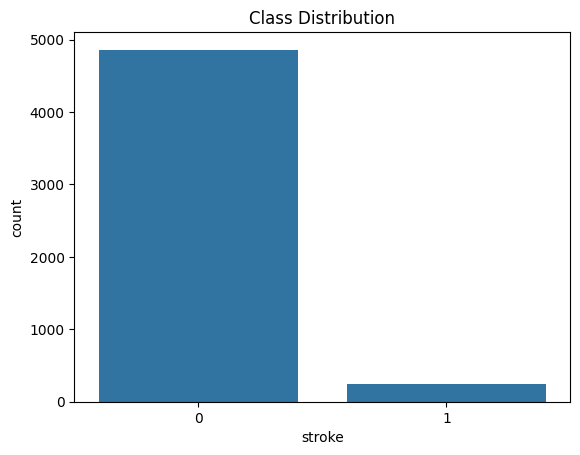

In [220]:
# Class balance
sns.countplot(x='stroke', data=df)
plt.title("Class Distribution")
plt.show()


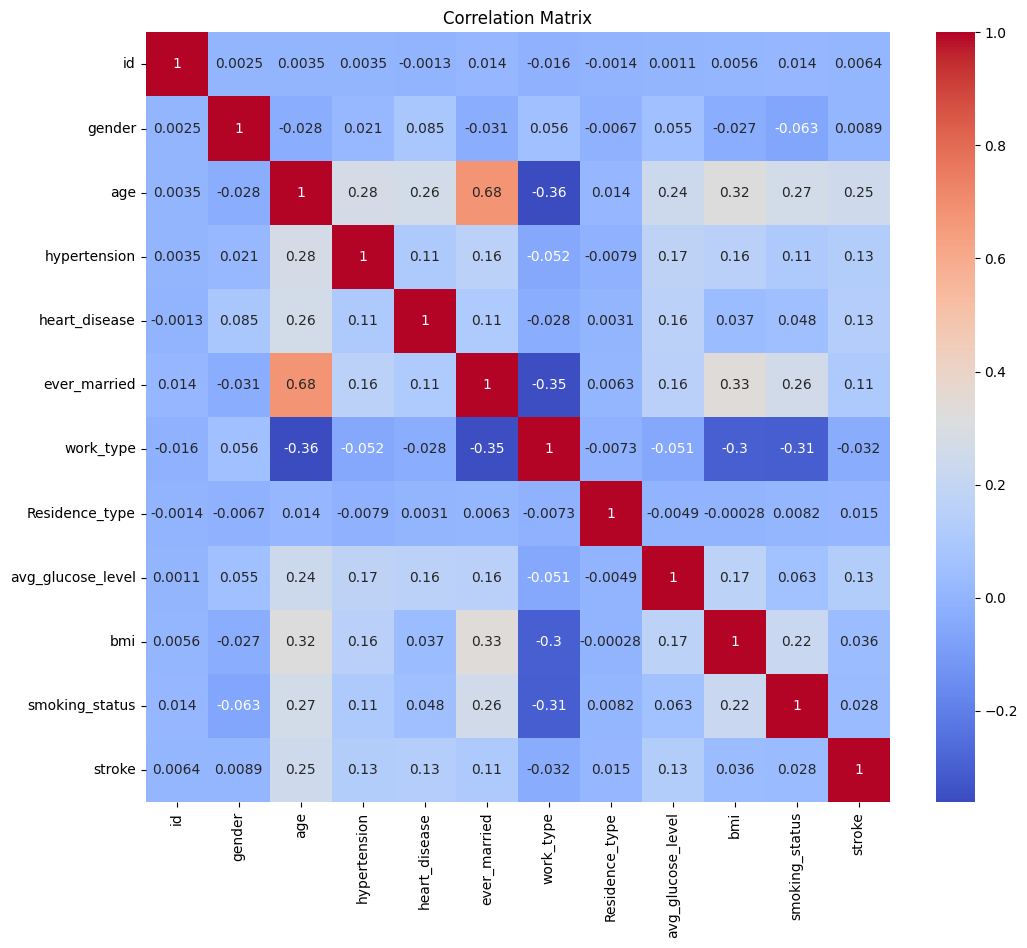

In [221]:
# Correlation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

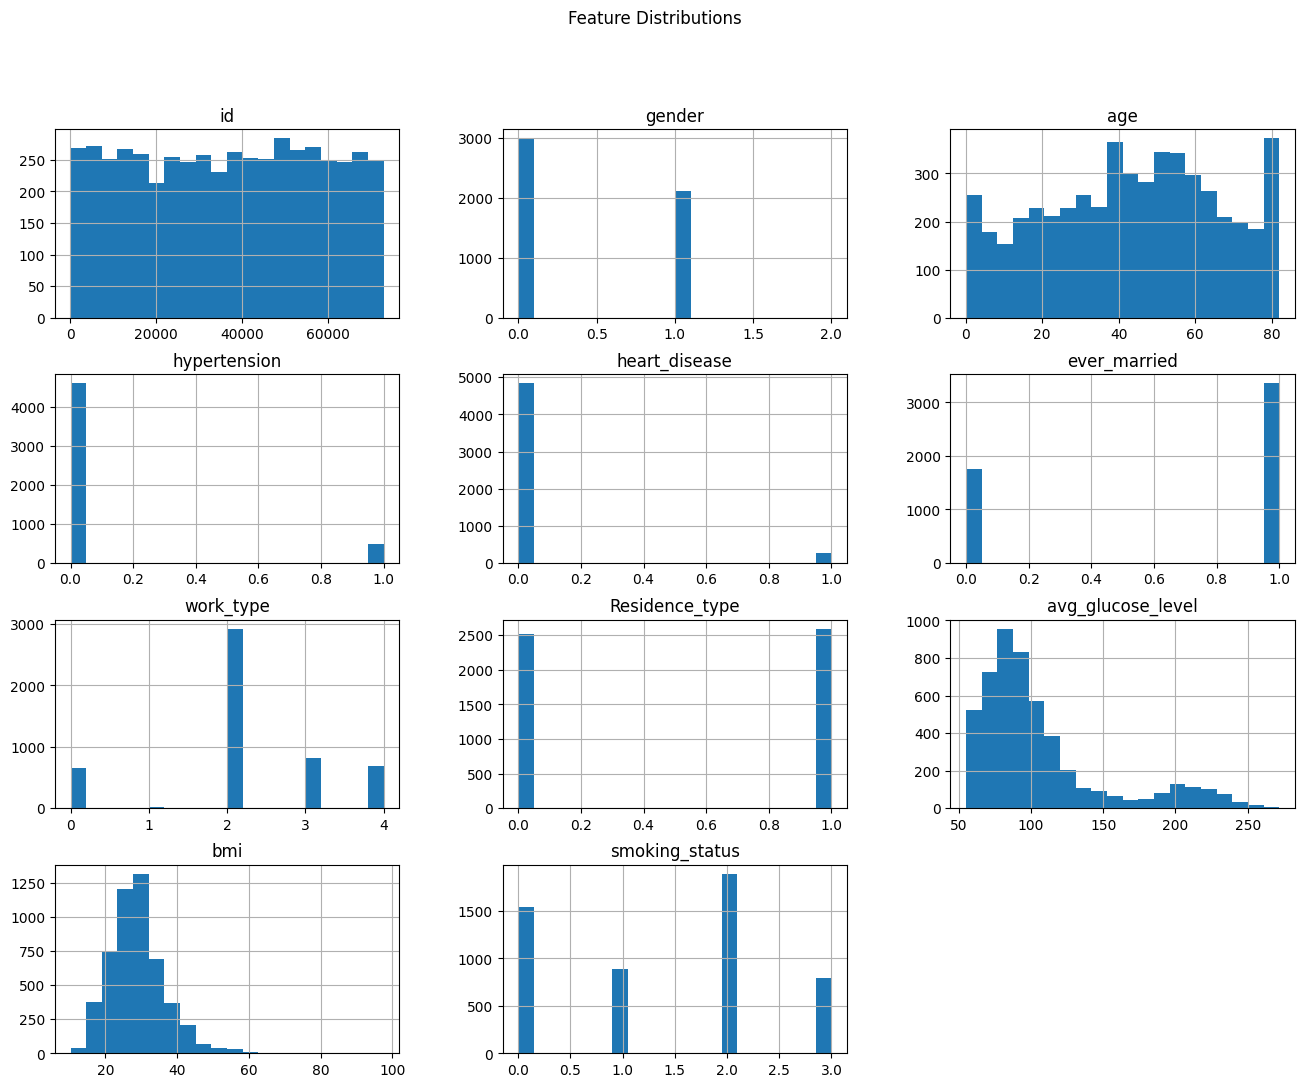

In [222]:
# Histograms
numeric_cols = df.select_dtypes(include=[np.number]).columns.drop('stroke')
df[numeric_cols].hist(bins=20, figsize=(16,12))
plt.suptitle("Feature Distributions")
plt.show()

In [223]:
#Split Data & Scale

In [224]:
X_columns = df.columns.drop('stroke')
X = df[X_columns]
y = df['stroke']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)


In [225]:
# Train Models

In [226]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None
    acc = accuracy_score(y_test, y_pred)
    print(f"=== {name} ===")
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred))
    if y_proba is not None:
        auc = roc_auc_score(y_test, y_proba)
        print("ROC AUC:", auc)


=== Logistic Regression ===
Accuracy: 0.9517286366601435
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1458
           1       1.00      0.01      0.03        75

    accuracy                           0.95      1533
   macro avg       0.98      0.51      0.50      1533
weighted avg       0.95      0.95      0.93      1533

ROC AUC: 0.8342661179698216
=== Random Forest ===
Accuracy: 0.9504240052185258
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1458
           1       0.00      0.00      0.00        75

    accuracy                           0.95      1533
   macro avg       0.48      0.50      0.49      1533
weighted avg       0.90      0.95      0.93      1533

ROC AUC: 0.816209419295839
=== Gradient Boosting ===
Accuracy: 0.9497716894977168
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1458
           1       

In [227]:
# ROC Curves

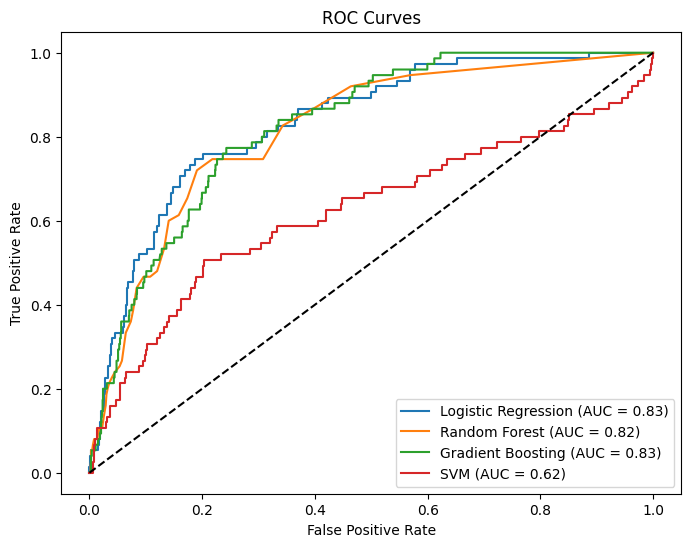

In [228]:
plt.figure(figsize=(8,6))
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


In [229]:
#Confusion Matrices

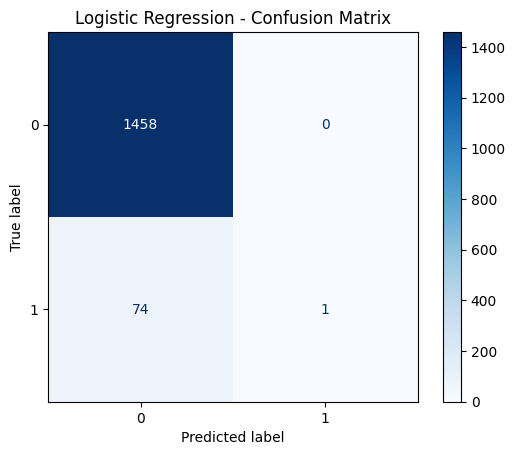

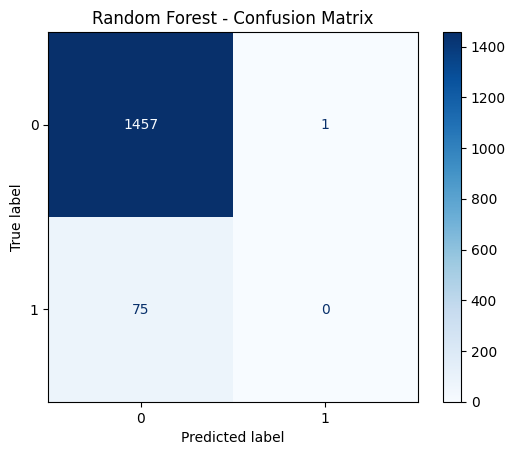

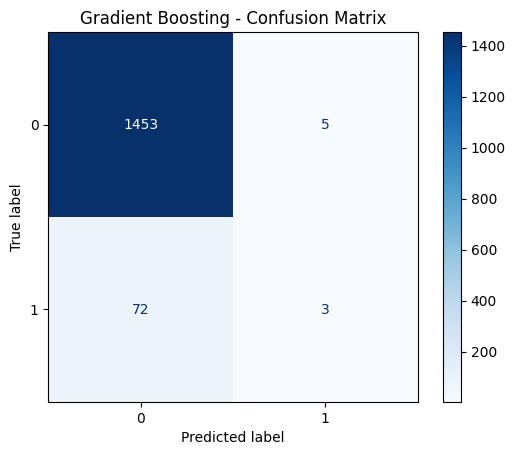

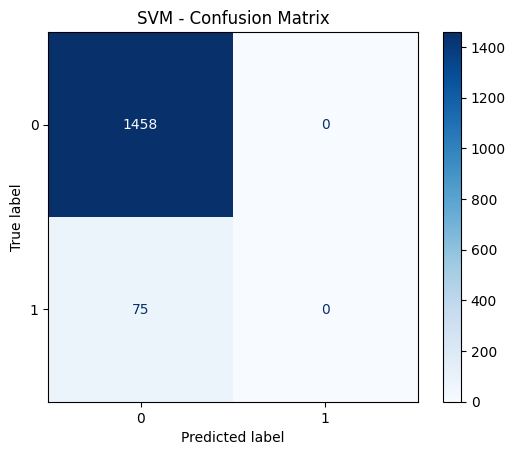

In [230]:
for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.show()


In [231]:
# Random Forest Feature Importance

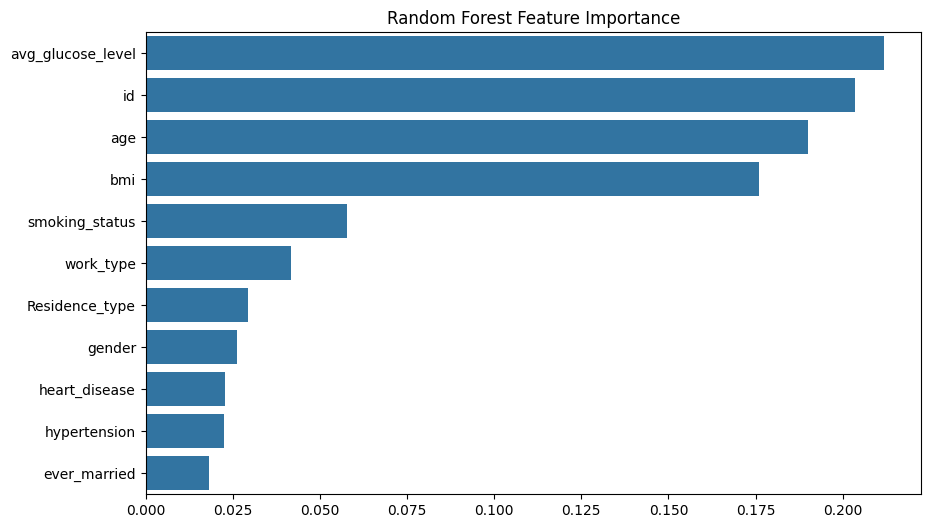

In [232]:
rf = models["Random Forest"]
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices], y=np.array(X_columns)[indices])
plt.title("Random Forest Feature Importance")
plt.show()


In [233]:
#SHAP Explainability

In [234]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test, feature_names=X_columns)


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

In [ ]:
# Permutation Feature Importance

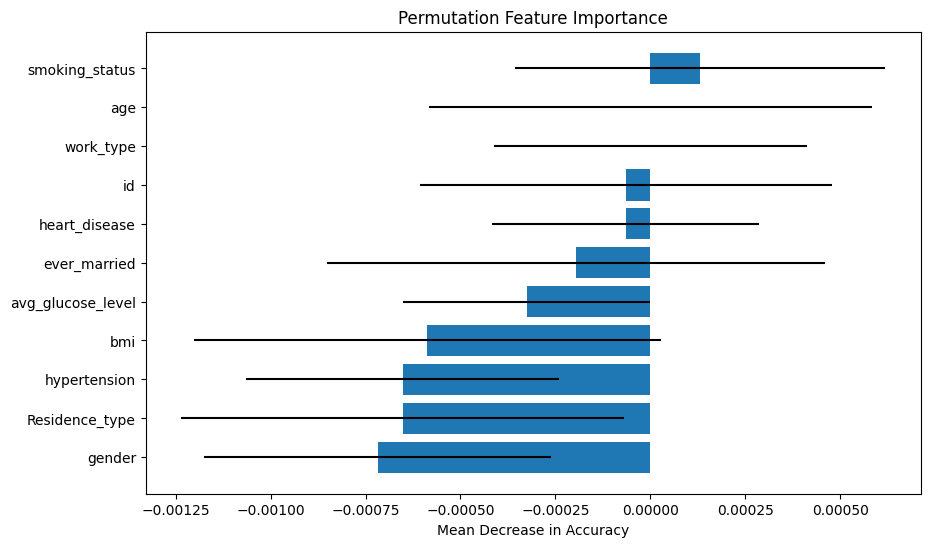

In [ ]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10,6))
plt.barh(
    np.array(X_columns)[sorted_idx],
    result.importances_mean[sorted_idx],
    xerr=result.importances_std[sorted_idx]
)
plt.title("Permutation Feature Importance")
plt.xlabel("Mean Decrease in Accuracy")
plt.show()


In [ ]:
# Partial Dependence Plots

In [ ]:
PartialDependenceDisplay.from_estimator(
    rf, X_test, features=[0,1,2], feature_names=X_columns
)
plt.suptitle("Partial Dependence Plots")
plt.show()


ValueError: cannot reshape array of size 1 into shape (2)

In [ ]:
# LIME Local Explanation

In [ ]:
lime_explainer = LimeTabularExplainer(
    training_data=X_train,
    feature_names=X_columns,
    class_names=['No Stroke', 'Stroke'],
    mode='classification'
)

i = 0  # Index of observation to explain
lime_exp = lime_explainer.explain_instance(
    X_test[i],
    rf.predict_proba,
    num_features=10
)

lime_exp.show_in_notebook(show_table=True)


ImportError: cannot import name 'display' from 'IPython.core.display' (C:\Users\michael\AppData\Roaming\Python\Python313\site-packages\IPython\core\display.py)